Этот ноутбук выполняет полный цикл анализа транзакций: от загрузки до ABC/XYZ-анализа и сохранения результатов. Реализованы best practices: обработка ошибок, функции, валидация, логирование, читаемость.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import logging
from datetime import datetime

# Настройка логирования
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# Настройка графиков
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 14

## 1. Загрузка данных

In [3]:
def load_data(filepath):
    """Загрузка CSV с проверкой."""
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Файл не найден: {filepath}")
    
    logger.info(f"Загрузка данных из {filepath}...")
    df = pd.read_csv(filepath)
    
    # Проверка колонок
    required_cols = ['tr_date', 'bcode', 'client', 'item', 'item_group', 'quantity', 'amount']
    missing = [col for col in required_cols if col not in df.columns]
    if missing:
        raise KeyError(f"Отсутствуют колонки: {missing}")
    
    # Парсинг даты
    df['tr_date'] = pd.to_datetime(df['tr_date'], format='%d.%m.%Y', dayfirst=True)
    
    logger.info(f"Загружено {len(df)} строк, {df.shape[1]} колонок.")
    return df

try:
    df = load_data('transactions_diy.csv')
except Exception as e:
    logger.error(f"Не удалось загрузить данные: {e}")
    raise

2025-12-11 10:32:58,364 - INFO - Загрузка данных из transactions_diy.csv...
2025-12-11 10:33:01,407 - INFO - Загружено 1008688 строк, 7 колонок.


## 2. Предобработка: расчёт цены

In [4]:
def add_price_column(df):
    """Добавляет столбец price = amount / quantity с обработкой ошибок."""
    logger.info("Рассчёт цены за единицу...")
    
    df = df.copy()
    
    # Фильтрация quantity = 0
    zero_qty = df[df['quantity'] == 0]
    if len(zero_qty) > 0:
        logger.warning(f"Удалено {len(zero_qty)} строк с quantity = 0")
        df = df[df['quantity'] != 0]
    
    df['price'] = df['amount'] / df['quantity']
    return df

df = add_price_column(df)
logger.info("Цена рассчитана.")

2025-12-11 10:33:06,141 - INFO - Рассчёт цены за единицу...
2025-12-11 10:33:06,225 - WARNING - Удалено 1 строк с quantity = 0
2025-12-11 10:33:06,407 - INFO - Цена рассчитана.


## 3. Анализ клиентов

In [5]:
def analyze_clients(df):
    """Анализ клиентов: сумма, количество, визиты."""
    logger.info("Анализ клиентов...")
    
    client_stats = (df.groupby('client')
                      .agg(
                          total_quantity=('quantity', 'sum'),
                          total_amount=('amount', 'sum'),
                          visit_days=('tr_date', 'nunique')
                      )
                      .reset_index()
                      .sort_values('total_amount', ascending=False))
    
    logger.info(f"Проанализировано {len(client_stats)} клиентов.")
    return client_stats

client_stats = analyze_clients(df)

2025-12-11 10:33:23,782 - INFO - Анализ клиентов...
2025-12-11 10:33:24,235 - INFO - Проанализировано 42746 клиентов.


## 4. ТОП-5 товаров

In [6]:
def get_top_products(df, n=5):
    """Возвращает ТОП-N товаров по сумме продаж."""
    top = (df.groupby('item')
             .agg(Кол_во=('quantity', 'sum'),
                  Сумма_продаж=('amount', 'sum'))
             .sort_values('Сумма_продаж', ascending=False)
             .head(n))
    return top

top_5_products = get_top_products(df, n=5)
logger.info("ТОП-5 товаров рассчитан.")

2025-12-11 10:33:29,500 - INFO - ТОП-5 товаров рассчитан.


## 5. ABC-анализ

In [7]:
def abc_analysis(df, threshold_a=80, threshold_b=95):
    sales = df.groupby('item')['amount'].sum().sort_values(ascending=False).reset_index()
    total = sales['amount'].sum()
    sales['cum_percent'] = (sales['amount'].cumsum() / total) * 100
    
    def assign(p):
        if p <= threshold_a: return 'A'
        elif p <= threshold_b: return 'B'
        else: return 'C'
    
    sales['ABC_group'] = sales['cum_percent'].apply(assign)
    return sales[['item', 'amount', 'cum_percent', 'ABC_group']]

abc_result = abc_analysis(df)
logger.info("ABC-анализ завершён.")

2025-12-11 10:33:34,891 - INFO - ABC-анализ завершён.


## 6. XYZ-анализ

In [8]:
def xyz_analysis(df):
    stats = df.groupby('item')['quantity'].agg(['mean', 'std']).fillna(0)
    stats['CV'] = (stats['std'] / stats['mean']) * 100
    stats['CV'] = stats['CV'].replace([np.inf, -np.inf], 0).fillna(0)
    
    stats['XYZ_group'] = pd.cut(stats['CV'],
                                bins=[0, 15, 25, 100],
                                labels=['X', 'Y', 'Z'],
                                include_lowest=True)
    return stats[['CV', 'XYZ_group']].reset_index()

xyz_result = xyz_analysis(df)
logger.info("XYZ-анализ завершён.")

2025-12-11 10:33:38,885 - INFO - XYZ-анализ завершён.


## 7. Матрица ABC × XYZ

In [9]:
abc_xyz_merge = pd.merge(abc_result[['item', 'ABC_group']],
                         xyz_result[['item', 'XYZ_group']],
                         on='item', how='inner')

abc_xyz_matrix = pd.crosstab(abc_xyz_merge['ABC_group'], 
                             abc_xyz_merge['XYZ_group'],
                             margins=True, margins_name='Total')

logger.info("Матрица ABC×XYZ создана.")

2025-12-11 10:33:43,184 - INFO - Матрица ABC×XYZ создана.


## 8. Фильтрация за последние 6 месяцев

In [10]:
end_date = pd.Timestamp('2019-10-31')
start_date = end_date - pd.DateOffset(months=6)

df_last_6m = df[(df['tr_date'] >= start_date) & (df['tr_date'] <= end_date)].copy()
logger.info(f"Отфильтровано {len(df_last_6m)} транзакций за 6 месяцев.")

2025-12-11 10:33:46,705 - INFO - Отфильтровано 350863 транзакций за 6 месяцев.


## 9. Визуализация

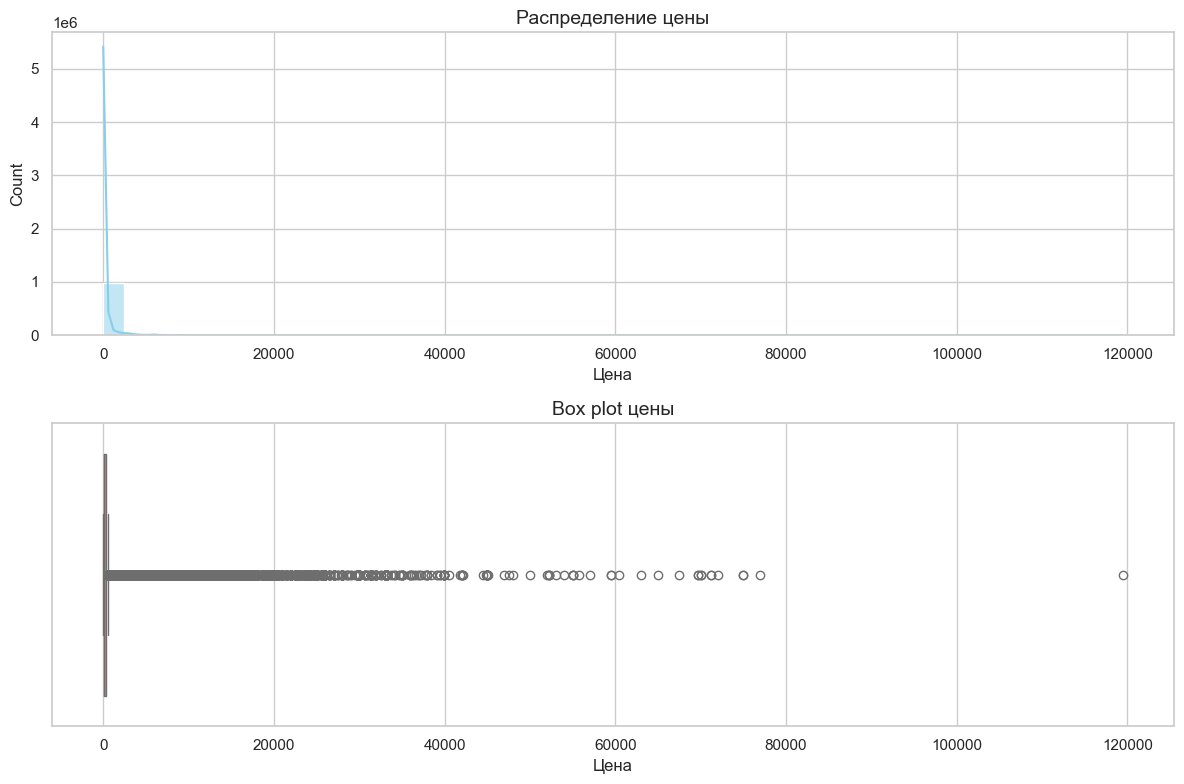

In [11]:
def plot_price_distribution(df):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    sns.histplot(df['price'], kde=True, ax=ax1, bins=50, color='skyblue')
    ax1.set_title('Распределение цены')
    ax1.set_xlabel('Цена')
    
    sns.boxplot(x=df['price'], ax=ax2, color='lightcoral')
    ax2.set_title('Box plot цены')
    ax2.set_xlabel('Цена')
    
    plt.tight_layout()
    plt.show()

plot_price_distribution(df)

## 10. Сохранение результатов

In [12]:
def save_results():
    files = [
        (top_5_products, 'top_5_products.csv'),
        (client_stats, 'client_statistics.csv'),
        (abc_result, 'abc_analysis.csv'),
        (xyz_result, 'xyz_analysis.csv'),
        (abc_xyz_matrix, 'abc_xyz_matrix.csv'),
        (df_last_6m, 'last_6_months_data.csv')
    ]
    
    for df_save, filename in files:
        index = True if 'matrix' in filename else False
        df_save.to_csv(filename, index=index)
        logger.info(f"Файл сохранён: {filename}")
        
        # Проверка
        if os.path.exists(filename):
            print(f"✅ {filename} (первые 5 строк):")
            print(pd.read_csv(filename).head(), "\n")
        
save_results()
logger.info("Анализ завершён.")

2025-12-11 10:34:09,768 - INFO - Файл сохранён: top_5_products.csv
2025-12-11 10:34:09,933 - INFO - Файл сохранён: client_statistics.csv


✅ top_5_products.csv (первые 5 строк):
   Кол_во  Сумма_продаж
0   18902       5373638
1    7250       3951361
2   15304       3918570
3    7705       3027786
4    3512       2113158 

✅ client_statistics.csv (первые 5 строк):


2025-12-11 10:34:10,179 - INFO - Файл сохранён: abc_analysis.csv


        client  total_quantity  total_amount  visit_days
0  client29182            3434       3887309         107
1  client15654            5457       1443255         174
2   client8778            1617        986618          17
3   client1704            1187        636101          23
4  client33032            1255        537397          74 

✅ abc_analysis.csv (первые 5 строк):


2025-12-11 10:34:10,380 - INFO - Файл сохранён: xyz_analysis.csv
2025-12-11 10:34:10,447 - INFO - Файл сохранён: abc_xyz_matrix.csv


       item   amount  cum_percent ABC_group
0  sku26161  5373638     0.854847         A
1  sku18199  3951361     1.483435         A
2  sku21947  3918570     2.106808         A
3  sku28128  3027786     2.588473         A
4   sku8342  2113158     2.924637         A 

✅ xyz_analysis.csv (первые 5 строк):
       item          CV XYZ_group
0      sku1   37.639940         Z
1     sku10   61.237244         Z
2    sku100   63.260430         Z
3   sku1000   52.635279         Z
4  sku10000  117.086403       NaN 

✅ abc_xyz_matrix.csv (первые 5 строк):
  ABC_group      X     Y      Z  Total
0         A   1527   297   2804   4628
1         B   2562   411   4597   7570
2         C   7566   646   8030  16242
3     Total  11655  1354  15431  28440 



2025-12-11 10:34:13,701 - INFO - Файл сохранён: last_6_months_data.csv


✅ last_6_months_data.csv (первые 5 строк):


2025-12-11 10:34:14,716 - INFO - Анализ завершён.


      tr_date          bcode       client      item  \
0  2019-04-30  code000104798   client9024  sku30513   
1  2019-04-30  code000104798   client9024   sku8025   
2  2019-04-30  code000104798   client9024  sku12414   
3  2019-04-30  code000104798   client9024   sku3437   
4  2019-04-30  code000104798  client32133   sku1489   

                     item_group  quantity  amount    price  
0      Товары для дачи и отдыха         1      95     95.0  
1      Товары для дачи и отдыха         1      43     43.0  
2  Оборудование для сада и дачи         1    2397   2397.0  
3  Оборудование для сада и дачи         1      78     78.0  
4                Садовая мебель         1   14990  14990.0   

